In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plot import plot_martingale_paths
from utils import *


In [2]:
## Load data (for computing changepoint location)
meps_data = get_meps_data()
n_meps = len(meps_data)
superconduct_data = get_superconduct_data()
n_superconduct = len(superconduct_data)
bike_sharing_data = get_bike_sharing_data()
n_bike_sharing = len(bike_sharing_data)


## Load results
meps_results = pd.read_csv('../results/meps-NN-covariate-shift_bias5.0-label_shift0-err_win50-cs_typeabs-nseeds10-Wfixed_cal_dyn_none-numTestUnshifted1000-test0Size0.33333.csv')
superconduct_results = pd.read_csv('../results/superconduct-NN-covariate-shift_bias2.0-label_shift0-err_win50-cs_typeabs-nseeds50-Wfixed_cal_dyn_none-numTestUnshifted1000-test0Size0.33333.csv')
bike_sharing_results = pd.read_csv('../results/bike_sharing-NN-covariate-shift_bias5.0-label_shift0-err_win50-cs_typeabs-nseeds50-Wfixed_cal_dyn_none-numTestUnshifted1000-test0Size0.33333.csv')

meps_bias = 6.0
superconduct_bias = 2.5
bike_sharing_bias = 5.0

n_seeds_all = [10, 50, 50]

n_dataset :  33005
fixed_cal_dyn
none
plotting coverage
plotting widths
n_dataset :  21263
fixed_cal_dyn
none
plotting coverage
plotting widths
n_dataset :  17379
fixed_cal_dyn
none
plotting coverage
plotting widths


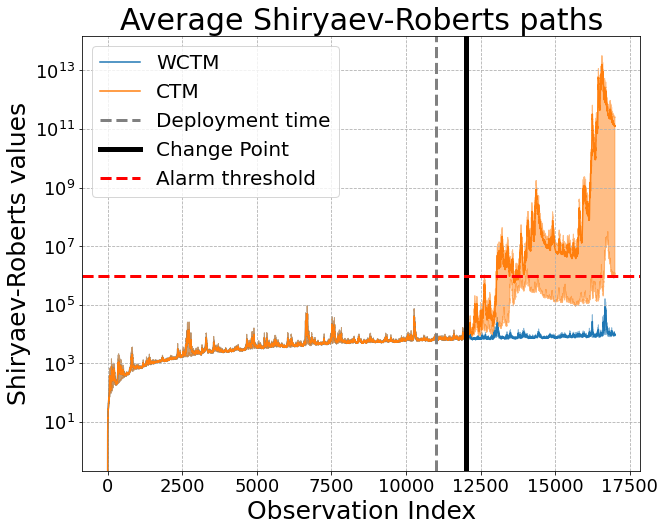

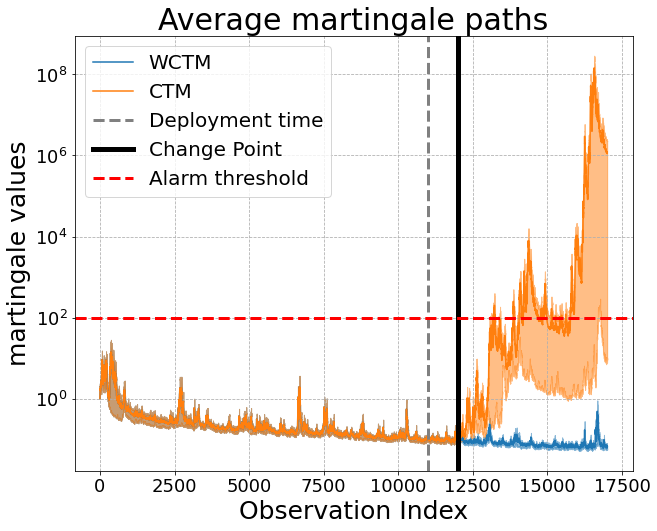

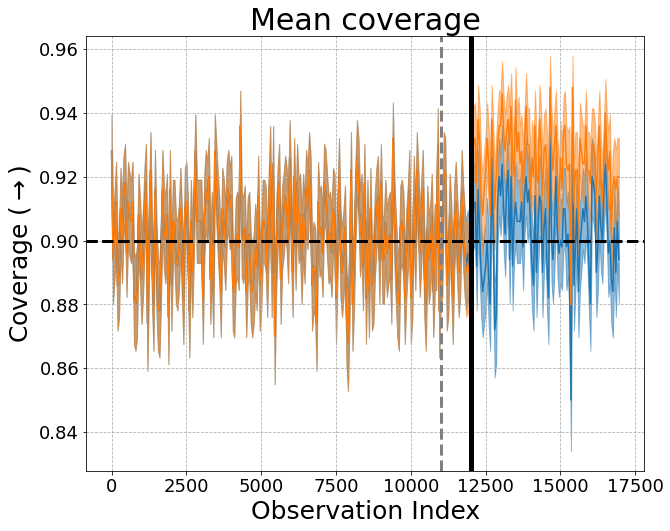

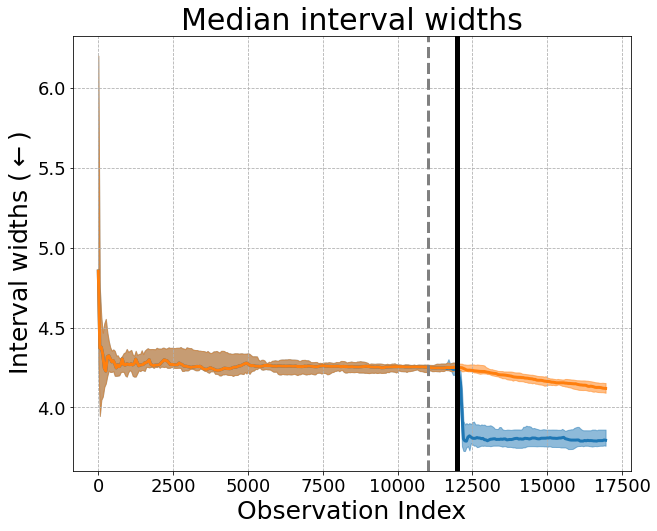

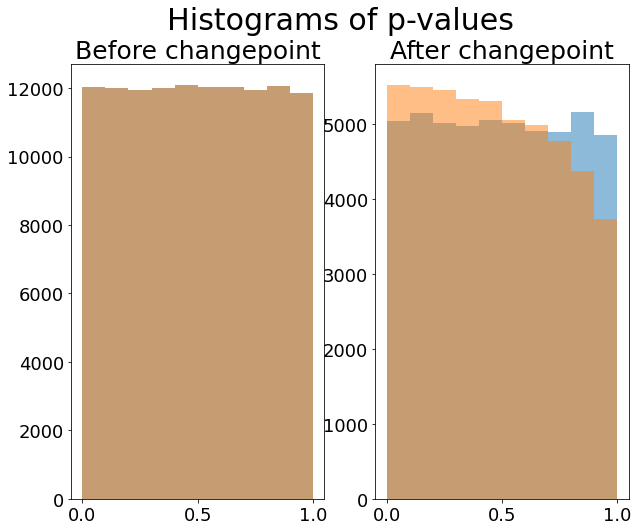

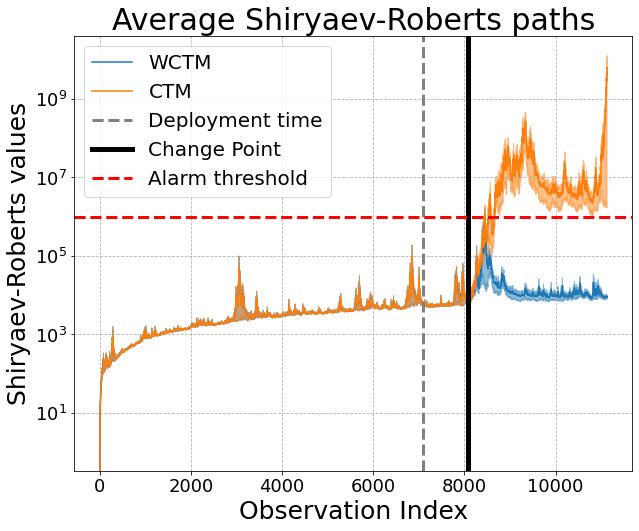

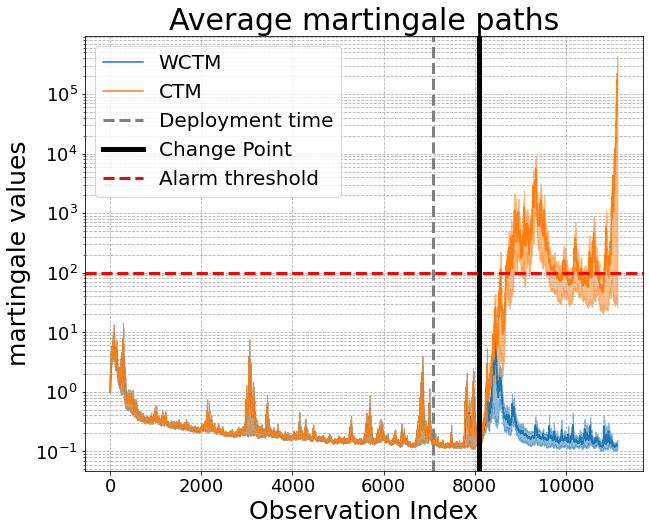

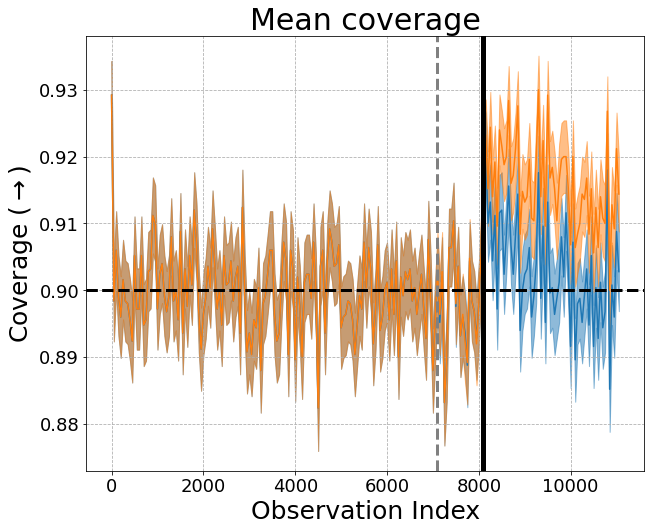

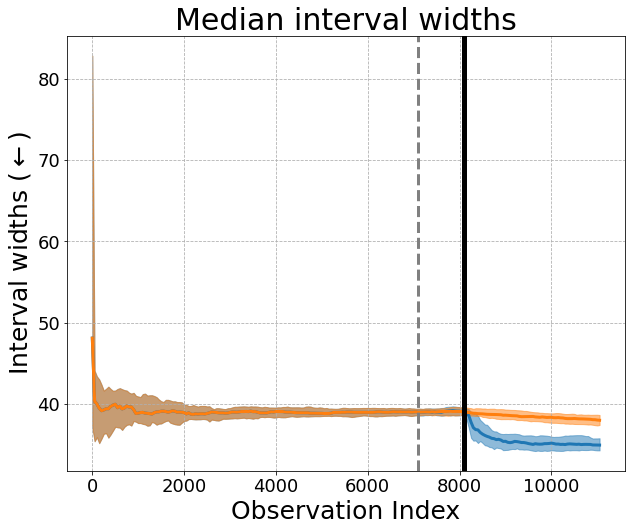

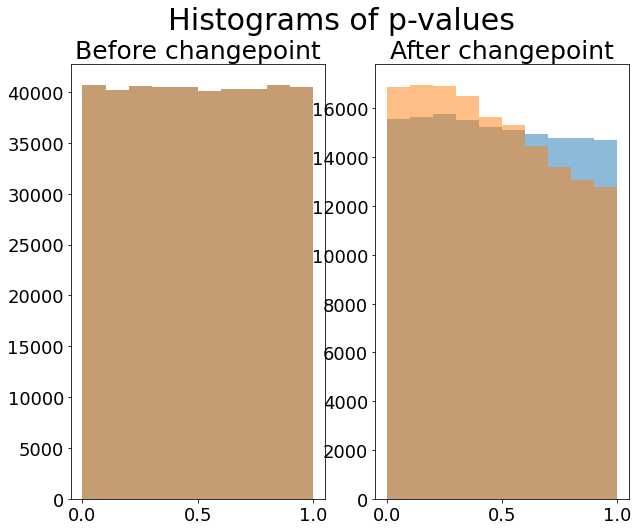

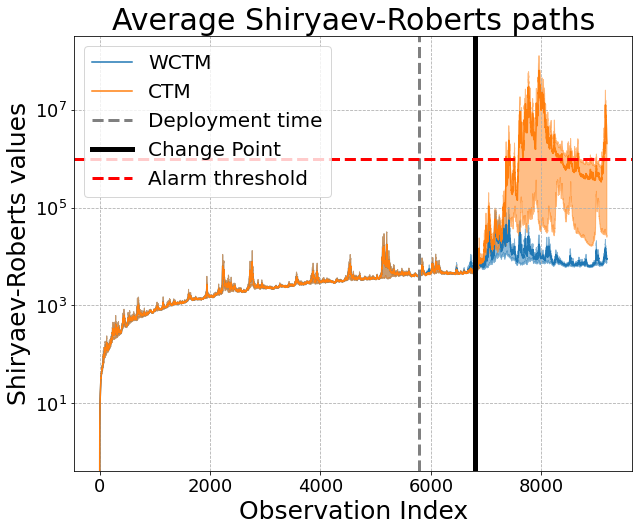

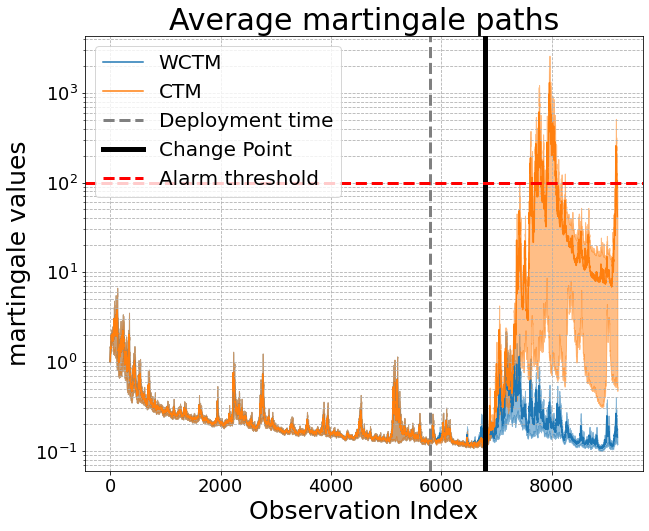

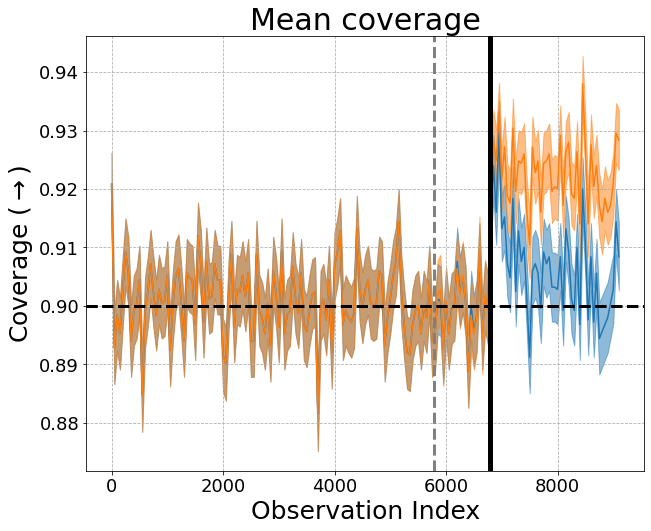

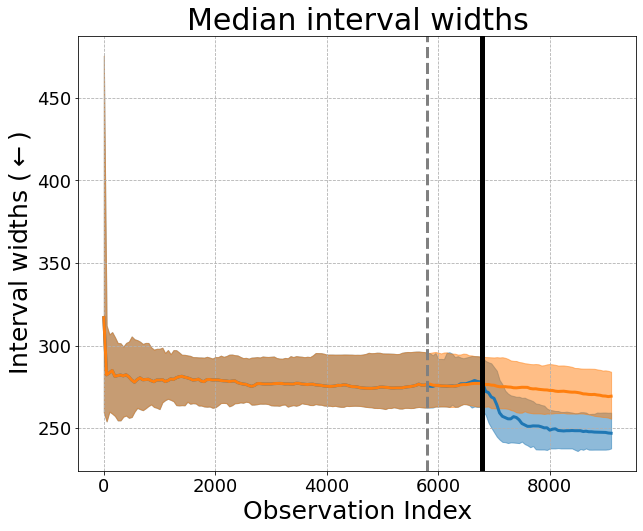

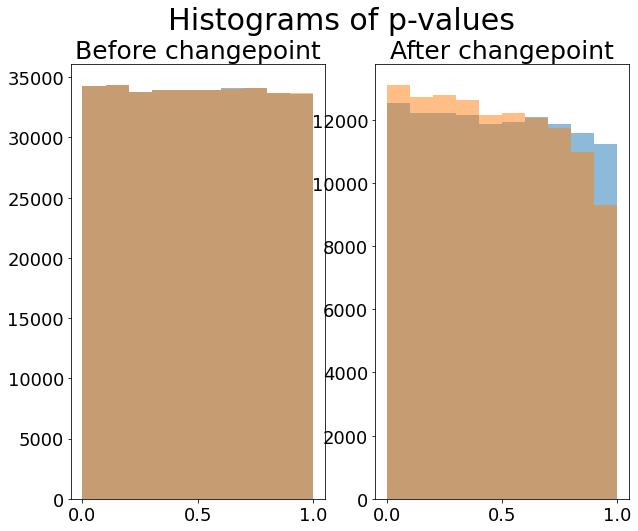

In [3]:

dataset_names = ['meps', 'superconduct', 'bike_sharing'] # 'meps',
test0_size = 0.33333
num_folds = 1
methods = ['fixed_cal_dyn', 'none']
methods_all = "_".join(methods)
n_seeds=50
errs_window=50
dataset1=None
dataset1_name=None
dataset0_shift_type='covariate'
label_shift=None
plot_errors=False
cs_type='abs'
muh_fun_name='NN'
training_schedule='variable'
num_test_unshifted = 1000


    
for d_i, dataset0_name in enumerate(dataset_names):
    results = eval(dataset0_name+'_results')
    n_seeds = n_seeds_all[d_i]
    
    cov_shift_bias = eval(dataset0_name+'_bias')
    
    num_obs = max(results['obs_idx'])+1
    
    n_dataset = eval('n_'+dataset0_name)
    print("n_dataset : ", n_dataset)
    
    change_point_index = n_dataset*(1-test0_size)/max(2,num_folds)+num_test_unshifted
    
    
    setting = '{}-{}-{}-shift_bias{}-label_shift{}-err_win{}-cs_type{}-nseeds{}-W{}-numTestUnshifted{}-test0Size{}'.format(
        dataset0_name,
        muh_fun_name,
        dataset0_shift_type,
        cov_shift_bias,
        label_shift,
        errs_window,
        cs_type,
        n_seeds,
        methods_all,
        num_test_unshifted,
        test0_size
    )

    ## Preparation for plotting
    sigmas_0_means_dict, sigmas_1_means_dict = {}, {}
    sigmas_0_stderr_dict, sigmas_1_stderr_dict = {}, {}
    martingales_0_means_dict, martingales_1_means_dict = {}, {}
    martingales_0_stderr_dict, martingales_1_stderr_dict = {}, {}
    errors_0_means_dict, errors_1_means_dict = {}, {}
    errors_0_stderr_dict, errors_1_stderr_dict = {}, {}
    coverage_0_means_dict = {}
    coverage_0_stderr_dict = {}
    widths_0_medians_dict = {}
    widths_0_lower_q_dict = {}
    widths_0_upper_q_dict = {}
    pvals_0_means_dict = {}
    pvals_0_stderr_dict = {}
    p_vals_cal_dict = {}
    p_vals_test_dict = {}
    
    
    
    for method in methods:
    
        ## Compute average and stderr values for plotting
#         paths_all = paths_dict_all[method]
        print(method)
        paths_all = results[results['method']==method]
    
        sigmas_0_means, sigmas_1_means = [], []
        sigmas_0_stderr, sigmas_1_stderr = [], []
        martingales_0_means, martingales_1_means = [], []
        martingales_0_stderr, martingales_1_stderr = [], []
        errors_0_means, errors_1_means = [], []
        errors_0_stderr, errors_1_stderr = [], []
        coverage_0_means = []
        coverage_0_stderr = []
        widths_0_medians = []
        widths_0_lower_q = []
        widths_0_upper_q = []
        pvals_0_means = []
        pvals_0_stderr = []

        ## For each fold/separate martingale path
        for i in range(0, num_folds):
            ## Compute average martingale values over trials
            sigmas_0_means.append(paths_all[['sigmas_0_'+str(i), 'obs_idx']].groupby('obs_idx').mean())
            sigmas_0_stderr.append(paths_all[['sigmas_0_'+str(i), 'obs_idx']].groupby('obs_idx').std() / np.sqrt(n_seeds))
            
            martingales_0_means.append(paths_all[['martingales_0_'+str(i), 'obs_idx']].groupby('obs_idx').mean())
            martingales_0_stderr.append(paths_all[['martingales_0_'+str(i), 'obs_idx']].groupby('obs_idx').std() / np.sqrt(n_seeds))


            ## Compute average and stderr absolute score (residual) values over window, trials
            errors_0_means_fold = []
            errors_0_stderr_fold = []
            coverage_0_means_fold = []
            coverage_0_stderr_fold = []
            widths_0_medians_fold = []
            widths_0_lower_q_fold = []
            widths_0_upper_q_fold = []
            pvals_0_means_fold = []
            pvals_0_stderr_fold = []
            for j in range(0, int(num_obs / errs_window)):
                ## Subset dataframe by window
                paths_all_sub = paths_all[paths_all['obs_idx'].isin(np.arange(j*errs_window,(j+1)*errs_window))]

                ## Averages and stderrs for that window
                errors_0_means_fold.append(paths_all_sub['errors_0_'+str(i)].mean())
                errors_0_stderr_fold.append(paths_all_sub['errors_0_'+str(i)].std() / np.sqrt(n_seeds*errs_window))

                ## Coverages for window
                coverage_0_means_fold.append(paths_all_sub['coverage_0_'+str(i)].mean())
                coverage_0_stderr_fold.append(paths_all_sub['coverage_0_'+str(i)].std() / np.sqrt(n_seeds*errs_window))
                
                ## Widths for window
                wid_med = paths_all_sub['widths_0_'+str(i)].median()
                widths_0_medians_fold.append(wid_med)
                widths_0_lower_q_fold.append(paths_all_sub['widths_0_'+str(i)].quantile(0.25))
                widths_0_upper_q_fold.append(paths_all_sub['widths_0_'+str(i)].quantile(0.75))

                ## P values for window
                pvals_0_means_fold.append(paths_all_sub['pvals_0_'+str(i)].mean())
                pvals_0_stderr_fold.append(paths_all_sub['pvals_0_'+str(i)].std() / np.sqrt(n_seeds*errs_window))


            ## Averages and stderrs for that fold
            errors_0_means.append(errors_0_means_fold)
            errors_0_stderr.append(errors_0_stderr_fold)

            ## Average coverages for fold
            coverage_0_means.append(coverage_0_means_fold)
            coverage_0_stderr.append(coverage_0_stderr_fold)
            
            ## Median widths for fold
            widths_0_medians.append(widths_0_medians_fold)
            widths_0_lower_q.append(widths_0_lower_q_fold)
            widths_0_upper_q.append(widths_0_upper_q_fold)

            ## Average pvals for fold
            pvals_0_means.append(pvals_0_means_fold)
            pvals_0_stderr.append(pvals_0_stderr_fold)

            
        
            if (dataset1 is not None):
                ## Compute average martingale values over trials
                sigmas_1_means.append(paths_all_abs[['sigmas_1_'+str(i), 'obs_idx']].groupby('obs_idx').mean())
                sigmas_1_stderr.append(paths_all[['sigmas_1_'+str(i), 'obs_idx']].groupby('obs_idx').std() / np.sqrt(n_seeds))
                
                martingales_1_means.append(paths_all[['martingales_1_'+str(i), 'obs_idx']].groupby('obs_idx').mean())
                martingales_1_stderr.append(paths_all[['martingales_1_'+str(i), 'obs_idx']].groupby('obs_idx').std() / np.sqrt(n_seeds))

                ## Compute average and stderr absolute score (residual) values over window, trials
                errors_1_means_fold = []
                errors_1_stderr_fold = []
                for j in range(0, int(num_obs/errs_window)):
                    ## Subset dataframe by window
                    paths_all_sub = paths_all_abs[paths_all_abs['obs_idx'].isin(np.arange(j*errs_window,(j+1)*errs_window))]

                    ## Averages and stderrs for that window
                    errors_1_means_fold.append(paths_all_sub['errors_1_'+str(i)].mean())
                    errors_1_stderr_fold.append(paths_all_sub['errors_1_'+str(i)].std()/ np.sqrt(n_seeds*errs_window))

                ## Averages and stderrs for that fold
                errors_1_means.append(errors_1_means_fold)
                errors_1_stderr.append(errors_1_stderr_fold)
                
                
        sigmas_0_means_dict[method], sigmas_1_means_dict[method] = sigmas_0_means, sigmas_1_means
        sigmas_0_stderr_dict[method], sigmas_1_stderr_dict[method] = sigmas_0_stderr, sigmas_1_stderr
        martingales_0_means_dict[method], martingales_1_means_dict[method] = martingales_0_means, martingales_1_means
        martingales_0_stderr_dict[method], martingales_1_stderr_dict[method] = martingales_0_stderr, martingales_1_stderr
        errors_0_means_dict[method], errors_1_means_dict[method] = errors_0_means, errors_1_means
        errors_0_stderr_dict[method], errors_1_stderr_dict[method] = errors_0_stderr, errors_1_stderr
        coverage_0_means_dict[method] = coverage_0_means
        coverage_0_stderr_dict[method] = coverage_0_stderr
        pvals_0_means_dict[method] = pvals_0_means
        pvals_0_stderr_dict[method] = pvals_0_stderr
        widths_0_medians_dict[method] = widths_0_medians
        widths_0_lower_q_dict[method] = widths_0_lower_q
        widths_0_upper_q_dict[method] = widths_0_upper_q
        
        
        
        ## Saving p-values together for histograms
        paths_cal = paths_all[paths_all['obs_idx'] < change_point_index]
        paths_test = paths_all[paths_all['obs_idx'] >= change_point_index]
        
        p_vals_cal = paths_cal['pvals_0_0']
        p_vals_test = paths_test['pvals_0_0']
        
        for i in range(1, num_folds):
            p_vals_cal = np.concatenate((p_vals_cal, paths_cal[f'pvals_0_{i}']))
            p_vals_test = np.concatenate((p_vals_test, paths_test[f'pvals_0_{i}']))
            
        p_vals_cal_dict[method] = p_vals_cal
        p_vals_test_dict[method] = p_vals_test
    
        
    plot_martingale_paths(
        dataset0_paths_dict=sigmas_0_means_dict,
        dataset0_paths_stderr_dict=sigmas_0_stderr_dict,
        dataset0_name=dataset0_name,
        martingales_0_dict=martingales_0_means_dict,
        martingales_0_stderr_dict=martingales_0_stderr_dict,
        dataset1_paths_dict=sigmas_1_means_dict, 
        dataset1_paths_stderr_dict=sigmas_1_stderr_dict,
        dataset1_name=dataset1_name,
        martingales_1_dict=martingales_1_means_dict,
        martingales_1_stderr_dict=martingales_1_stderr_dict,
        errors_0_means_dict=errors_0_means_dict,
        errors_1_means_dict=errors_1_means_dict,
        errors_0_stderr_dict=errors_0_stderr_dict,
        errors_1_stderr_dict=errors_1_stderr_dict,
        p_vals_cal_dict=p_vals_cal_dict,
        p_vals_test_dict=p_vals_test_dict,
        errs_window=errs_window,
        change_point_index=change_point_index,
        title="Average paths of Shiryaev-Roberts Procedure",
        ylabel="Shiryaev-Roberts Statistics",
        martingale=["Shiryaev-Roberts", "martingale"],
        dataset0_shift_type=dataset0_shift_type,
        cov_shift_bias=cov_shift_bias,
        label_shift_bias=label_shift,
        plot_errors=plot_errors,
        n_seeds=n_seeds,
        cs_type=cs_type,
        setting=setting,
        coverage_0_means_dict=coverage_0_means_dict,
        coverage_0_stderr_dict=coverage_0_stderr_dict,
        pvals_0_means_dict=pvals_0_means_dict,
        pvals_0_stderr_dict=pvals_0_stderr_dict,
        widths_0_medians_dict=widths_0_medians_dict,
        widths_0_lower_q_dict=widths_0_lower_q_dict,
        widths_0_upper_q_dict=widths_0_upper_q_dict,
        methods=methods,
        schedule=training_schedule,
        num_test_unshifted=num_test_unshifted
    )
    
    